# A game of flipper with MNIST


#### Flipped-MNIST dataset
Let's flip MNIST images at random, and train a classifier to detect flips. 

#### Training method
- Transfer learning with resnet18
- Training of final layer only

#### Result
The accuracy on the validation set is 87.6%.

## Approach


### Using PyTorch and transformations
The straightforward approach is to store MNIST and a flipped copy of MNIST in different directories on disk, and use a library like Fastai or Keras to quickly build a classifier. This the best bet if you want to get good results in a short time.

As I am used to work with Keras and Fast.ai, and decided that I want handle the details of training myself this time. It turned out to be a great learning process. As expected, the result seemed not as good as one can get in an hour or two with Fast.ai. So in the end I re-did my analysis with Fast.ai.

As I wanted to get to know the data processing tools of Pytorch better, I implemented apply random flip transformations to the existing MNIST dataset in TorchVision. Initially I believed that this solution would be elegant and easy to re-use for other datasets in torchvision. This did not work out the way I hoped: the code became quite messy and inefficient.



### Torch datasets
The transformation that I wrote flips a coin, each time a example is requested from the dataset. If the outcome is head, the image is flipped vertically and the label is overwritten with the number 1. If the outcome is tail, the image is left as is and the label is overwritten with the number 0. 

Now, the constructor of `torchvision.dataset.MNIST` accepts transformations that act either on the images or on the data. 

```python
trainset = torchvision.datasets.MNIST(root=PATH, train=True,
                                            download=True, transform=image_transforms,
                                            target_transform=target_transforms)
```

This is somewhat problematic as the transformation of the labels should be consistent with the transformation of the images. The `PinballFlip` object offers two  transformation that are consistent, by maintaining an internal state.

```python
flipper = PinballFlip(p=0.5)
```
See `flipper/data/ultils.py` for details. 

The pinball transformations are applied together with a few more image transformations:
```python
image_transforms = transforms.Compose(
        [transforms.Resize(size=224),
         flipper.image_transform,
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         duplicate_channels
         ])
target_transforms = flipper.target_transform
```
The image scaling and channel duplication are nothing but a practical way to use a pre-trained Resnet with minimal effort. 
I admit: it is not pretty, but it saves some time.

### Visualizing random flips
In the plots below it can be seen that labels are consistent with the random flips.

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from flipper.data.util import get_flipped_mnist_datasets
from flipper.script.main import parser
from flipper.model.model import pretrained_resnet18
from flipper.train.util import train_model, ModelTrainer
PATH = '../../data'
trainset, devset = get_flipped_mnist_datasets(PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


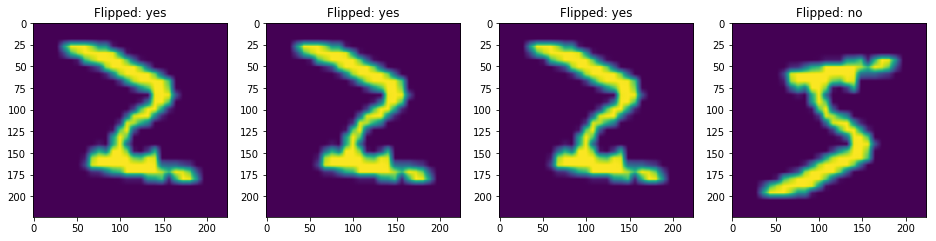

In [7]:
plot_random_flips(trainset, sample_index=0)

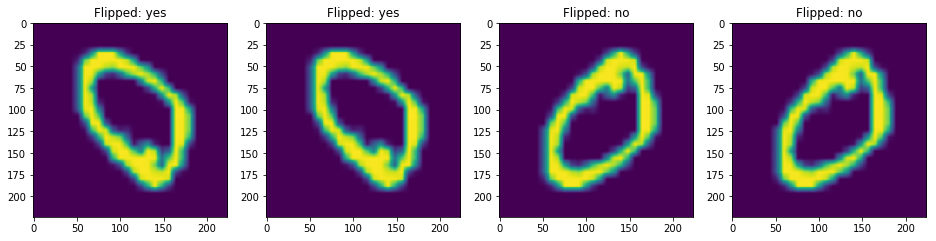

In [8]:
plot_random_flips(trainset, sample_index=1)

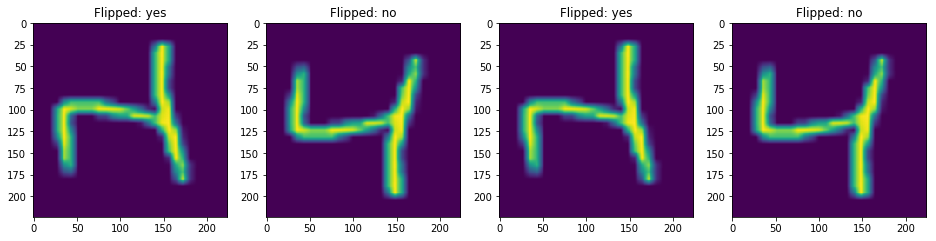

In [9]:
plot_random_flips(trainset, sample_index=2)

### Observations
Even though 0 is supposedly symmetric under flips, in practice it not. We see
- A clear starting point 
- Some skew
- Differences in curvature

This leads me to believe that the Bayes rate for this problem will be high (say 99%, but more images should be inspected before such a claim can be made).

### Training a model

Transfer learning is the quickest way to create a neural network classifier on simple images. Below I train the Resnet18 architecture to get a quick impression of how a classifier performs on this dataset. 

After one epoch the evaluation accuracy is 88.9 percent. This is a sign that we are on the right way. As the learning rate has not been tuned and the network was trained for one epoch only, chances are that this number goes up with a little more effort.

In [ ]:
model = pretrained_resnet18()
trainer = ModelTrainer(model, trainset, devset, args)
for i in range(14000):
    trainer.train_batch()
trainer.plot_losses(alpha=0.01)

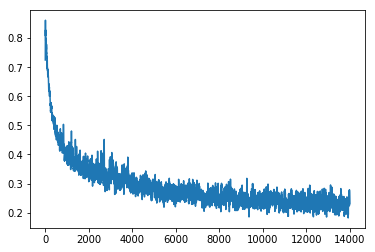

In [226]:
trainer.plot_losses()

In [232]:
trainer.evaluate_dev(n_batches=1000)

100%|██████████| 1000/1000 [00:08<00:00, 121.99it/s]


{'loss': 0.29651532, 'acc': 0.87624999999999997}

### Conclusions
The classifier seems not to do so well, which may have to do with the fact that learning rate is not optimal. After implementing data transformations and trainings functions the code was so messy that I did not continue to write code for doing a error analysis or model optimization.

Writing your own functions for data processing and training in Pytorch requires some practice. Probably the design gets better after a couple of attempts.

To see how Fast.ai scores on the MNIST-flipper dataset, I will write it to the filesystem and use to build a quick classifier in another notebook.

In [ ]:
import pathlib
from flipper.data.util import save_flipped_mnist
input_path = pathlib.Path('/home/paperspace/data/mnist')
output_path = pathlib.Path('/home/paperspace/data/flipped_mnist/')
save_flipped_mnist(input_path, output_path)

Processing...
Done!
